In [1]:
"""
This implementation is based on the guidance from the SpinningUp article:
https://spinningup.openai.com/en/latest/algorithms/td3.html
"""

from torch import nn
import torch.nn.functional as F
import torch
import random 
import matplotlib.pyplot as plt
import numpy as np

## ----------------- Helpers ---------------- ## 

def flatten(nestedTuple: tuple):
    """
    flatten input dimensions for NNs
    """
    merged = []
    for item in nestedTuple:
        if isinstance(item, tuple) or isinstance(item, list):
            for i in item:
                merged.append(i)
        else:
            merged.append(item)  
    return merged   

## This function aims to help updating target actor/critic parameters
def targetUpdater(normalModel, targetModel, lRate = 0.3):
    for normalParam, targetParam in zip(normalModel.parameters(), targetModel.parameters()):
        targetParam.data.copy_(targetParam.data * (1.0 - lRate) + normalParam.data * lRate)
## This function aims to initilize target actor/critic parameters with normal Actor/Critc 
def initializer(normalModel, targetModel):
    for normalParam, targetParam in zip(normalModel.parameters(), targetModel.parameters()):
        targetParam.data.copy_(normalParam.data)
    
## ------------------ Actor ----------------- ## 

class Actor(nn.Module):
    """
    hidden layer can be further defined using another tuple e.g. (30, (128,64), 8) 
    or simply define in one tuple (30, 128, 64, 8)
    """
    def __init__(self, structure, use_dropout = False):
        
        super().__init__()
        
        layers = []
        ## Activation function:
        self.activation  = nn.ReLU()
        
        # Automatic population of FC network
        dim = flatten(structure)
        dim_shifted = dim[1:]
        
        for i in range(len(dim)-1):
            layers.append(nn.Linear(dim[i], dim_shifted[i]))
            
            ## Just in case for mitigating overfitting ...
            if use_dropout and i != len(dim)-2:
                layers.append(nn.Dropout(p = 0.2))
            
            if i != len(dim)-2:
                layers.append(self.activation)
        self.model = nn.Sequential(*layers)
        
    def forward(self, states):
        output = self.model(states)
        ## This is to scale back the actions to (-1, 1) for Ant environment !Need to change for other environmen
        output = torch.tanh(output) 
        
        return output
    
## -------------------Critic ---------------- ## 
class Critic(nn.Module):
    """
    Critic network input dimension must equal the states_dim + actions_dim
    """
    def __init__(self, structure, use_dropout = False):
        super().__init__()
        
        layers = []
        ## Activation function:
        self.activation  = nn.ReLU()
        
        # Automatic population of FC network
        dim = flatten(structure)
        dim_shifted = dim[1:]
        
        for i in range(len(dim)-1):
            layers.append(nn.Linear(dim[i], dim_shifted[i]))
            
            ## Just in case for mitigating overfitting ...
            if use_dropout and i != len(dim)-2:
                layers.append(nn.Dropout(p = 0.2))
                
            if i != len(dim)-2:
                layers.append(self.activation)
        self.model = nn.Sequential(*layers)
        
    def forward(self, states, actions):
        
        ## concatenate states and actions, order shouldn't really matter
        ## Normalise action for ANYmal
        inputs = torch.cat([states, actions], 1)
        output = self.model(inputs)
        return output


## -------------------Replay ---------------- ## 
class ReplayMemory():
    
    def __init__(self, size=500):
        self.size = size
        self.memory = []
        
    def addMemory(self, transition):
        """
        Transition composition:
        State, Action, Reward, `State
        """
        if self.isFull():
            ## If memory is full, remove the first stored elements
            self.memory.pop(0)
            
        self.memory.append(transition)
                
    def sample(self, batchSize):
        ## This is a very slow implementation - should be optimized if possible
        batch = random.sample(self.memory, batchSize)
        state, action, reward, stateNext, terminated = [], [], [], [], []
        for transition in batch:
            state.append(transition[0])
            action.append(transition[1])
            reward.append(transition[2])
            stateNext.append(transition[3])
            terminated.append(transition[4])
        
        return state, action, reward, stateNext, terminated
    
    def isFull(self):
        return len(self.memory)==self.size
    
    def getSize(self):
        return len(self.memory)


## ------------------- Target policy smoothing ---------------- ## 
class policySmooth:
    def __init__(self,  actionSpace, std = 0.1, clip = 0.3):
        
        self.std = std
        self.clip = clip
        self.size = actionSpace.shape[0]
        ## normalise upper lower limit for ANYmal
        self.high = actionSpace.high / 80
        self.low = actionSpace.low / 80
        
    def getAction(self, actionIn, noiseClip = True):
        noise = np.random.normal(0, self.std, self.size)
        
        ## For action no clipping, for target action apply clip
        if noiseClip:
            noise = np.clip(noise, -self.clip, self.clip)
        action = actionIn + noise
        
        return np.clip(action, self.low, self.high)


/home/linghao/env/p37_r/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch.optim as optim

class TD3Agent:
    
    def __init__(self, actionSpace, actorStructure:tuple, criticStructure:tuple, use_dropout = False, actorLRate = 0.0003, criticLRate = 0.0003, criticLoss = 'HL', gamma = 0.9, targetUpdaterLRate = 0.3, replayMemorySize = 500, batchSize = 128, policyDelay = 2, gpu = True):
        
        self.actor = Actor(structure=actorStructure, use_dropout = use_dropout)
        self.critic1 = Critic(structure=criticStructure, use_dropout = use_dropout)
        self.critic2 = Critic(structure=criticStructure, use_dropout = use_dropout)
        
        self.targetActor = Actor(structure=actorStructure, use_dropout = use_dropout)
        self.targetCritic1 = Critic(structure=criticStructure, use_dropout = use_dropout)
        self.targetCritic2 = Critic(structure=criticStructure, use_dropout = use_dropout)
        
        self.batchSize = batchSize
        self.targetUpdaterLRate = targetUpdaterLRate
        self.gamma = gamma
        self.gpu = gpu
        self.policyDelay = policyDelay
        if self.gpu:
            self.cuda()
        
        ## initialise target models 
        initializer(self.actor, self.targetActor)
        initializer(self.critic1, self.targetCritic1)
        initializer(self.critic2, self.targetCritic2)
        
        ## initialise replay memory and random process
        self.pSmooth = policySmooth(actionSpace)
        self.rMemory = ReplayMemory(replayMemorySize)
 
        
        ## initialise optimizer
        self.actorOptim = optim.Adam(self.actor.parameters(), lr=actorLRate)
        self.criticOptim1 = optim.Adam(self.critic1.parameters(), lr=criticLRate)
        self.criticOptim2 = optim.Adam(self.critic2.parameters(), lr=criticLRate)
        
        ## initialise Loss for critic, either Huber (default) or MSE (otherwise)
        if criticLoss == 'HL':
            self.criticCriteria1 = nn.HuberLoss()
            self.criticCriteria2 = nn.HuberLoss()
        
        else:
            self.criticCriteria1 = nn.MSELoss()
            self.criticCriteria2 = nn.MSELoss()
    def updatePolicy(self, num):
        ## Assuming sufficient replay memory has been acquired
        
        ## 1. Sample (S, A, R, S`) in replay memory

        state, action, reward, stateNext, terminated = self.rMemory.sample(self.batchSize)

        if self.gpu:
            state = torch.cuda.FloatTensor(state)
            action = torch.cuda.FloatTensor(action)
            reward = torch.cuda.FloatTensor(reward)
            stateNext = torch.cuda.FloatTensor(stateNext)
            terminated = torch.cuda.FloatTensor(terminated)

        else:
            state = torch.FloatTensor(state)
            action = torch.FloatTensor(action)
            reward = torch.FloatTensor(reward)
            stateNext = torch.FloatTensor(stateNext)
            terminated = torch.FloatTensor(terminated)

        ## 2. Gradient of actor and critic  

        targetAction = self.pSmooth.getAction(self.targetActor(stateNext).detach().cpu().numpy(), noiseClip=True)
        if self.gpu:
            targetAction = torch.cuda.FloatTensor(targetAction)
        else:
            targetAction = torch.FloatTensor(targetAction)
        Q1 = self.targetCritic1(stateNext.detach(), targetAction.detach())
        Q2 = self.targetCritic2(stateNext.detach(), targetAction.detach())

        ## SMALLER Q Proceed (this verion consider actions individually)
        if Q1.mean() > Q2.mean():
            Q = Q2
        else:
            Q = Q1

        y = self.gamma * (1 - terminated) * Q + reward
        y.requires_grad_()


        yBar1 = self.critic1(state, action)
        yBar2 = self.critic2(state, action)

        criticLoss1 = self.criticCriteria1(yBar1, y)
        criticLoss2 = self.criticCriteria2(yBar2, y)

        ## backward losses
        self.criticOptim1.zero_grad()
        criticLoss1.backward(retain_graph = True)
        self.criticOptim1.step()

        self.criticOptim2.zero_grad()
        criticLoss2.backward()
        self.criticOptim2.step()

        ## update actor when delay condition is met
        if num % self.policyDelay == 0:
            actorLoss = -self.critic1(state, self.actor(state)).mean()
            self.actorOptim.zero_grad()
            actorLoss.backward()
            self.actorOptim.step()
        ## 3. Update target actor / critic
            targetUpdater(self.critic1, self.targetCritic1, self.targetUpdaterLRate)
            targetUpdater(self.critic2, self.targetCritic2, self.targetUpdaterLRate)
            targetUpdater(self.actor, self.targetActor, self.targetUpdaterLRate)


    
    ## Add option to discard noise in eval mode
    def getAction(self, states, eval = False):
        if self.gpu:
            states = torch.cuda.FloatTensor(states)
        else:
            states = torch.FloatTensor(states)
        
        action = self.actor(states).detach().cpu().numpy()
        
        # Action selection without noise clip
        if not eval:
            action = self.pSmooth.getAction(action, noiseClip=False)
            
        return action
    
    def cuda(self):
        ## Move all models to GPU
        if torch.cuda.is_available():
            self.actor.cuda()
            self.critic1.cuda()
            self.critic2.cuda()
            self.targetActor.cuda()
            self.targetCritic1.cuda()
            self.targetCritic2.cuda()
        else:
            raise ValueError("No Cuda Available")
            
    def cpu(self):
        ## Move all models back to CPU
        self.actor.cpu()
        self.critic1.cpu()
        self.critic2.cpu()
        self.targetActor.cpu()
        self.targetCritic1.cpu()
        self.targetCritic2.cpu()
        
    def evalMode(self):
        ## Evaluation mode for Agent showcase 
        self.actor.eval()
        self.critic1.eval()
        self.critic2.eval()
        self.targetActor.eval()
        self.targetCritic1.eval()  
        self.targetCritic2.eval() 
        
    def trainMode(self):
        ## Training mode for updating parameters
        self.actor.train()
        self.critic1.train()
        self.critic2.train()
        self.targetActor.train()
        self.targetCritic1.train() 
        self.targetCritic2.train() 
        
    def saveModel(self, path):
        torch.save(self.actor.state_dict(),f'{path}/actor.pkl')
        torch.save(self.targetActor.state_dict(),f'{path}/targetActor.pkl')
        
        torch.save(self.critic1.state_dict(),f'{path}/critic1.pkl')
        torch.save(self.critic2.state_dict(),f'{path}/critic2.pkl')
        
        torch.save(self.targetCritic1.state_dict(),f'{path}/targetCritic1.pkl')
        torch.save(self.targetCritic2.state_dict(),f'{path}/targetCritic2.pkl')    
        
    def loadModel(self, path):
        self.actor.load_state_dict(torch.load(f'{path}/actor.pkl'))
        self.targetActor.load_state_dict(torch.load(f'{path}/targetActor.pkl'))
        
        self.critic1.load_state_dict(torch.load(f'{path}/critic1.pkl'))
        self.critic2.load_state_dict(torch.load(f'{path}/critic2.pkl'))
        
        self.targetCritic1.load_state_dict(torch.load(f'{path}/targetCritic1.pkl'))
        self.targetCritic2.load_state_dict(torch.load(f'{path}/targetCritic2.pkl'))

In [3]:
def train(agent, env, epochs, replayMemorySize, updateStart, printEvery = 100, savePath=None):

    # ## Training Loop
    try:
        modelSaveCounter = 0
        maxR = -np.inf
        rewardTracking = []
        rewardAvg = []
        survival = []
        moving = []
        for e in range(epochs):
            state = env.reset()    
            episodeR = 0
            survT = 0
            t = 0
            move = 0
            # Training loop for each episode
            while True:
                
                # Fill in the replay memory
                action = agent.getAction(state)
                try:
                    stateNext, reward, terminated, truncated, info = env.step(action)                    
                    agent.rMemory.addMemory((state, action, np.array([reward]), stateNext, np.array([terminated])))

                    ## Update policy when memory is ready
                    if agent.rMemory.getSize() > updateStart: 
                        agent.updatePolicy(t)
                        t+=1

                    ## renew state and action
                    state = stateNext
                    episodeR += reward
                    survT += 1
                    move += info['reward']['direction']
                except:
                    break
                    
                if terminated or truncated:
                    break
            survival.append(survT)    
            rewardTracking.append(episodeR)
            rewardAvg.append(np.mean(rewardTracking[-10:]))
            moving.append(move)
            
            if e > 5 and rewardTracking[-1] > maxR:
                maxR = rewardTracking[-1]
            
                ## Only save model if reward increased
                if savePath!=None:
                    agent.saveModel(savePath)
                    modelSaveCounter += 1
                
            if (e+1)%printEvery == 0:
                print(f"Episode {e+1}: reward: {episodeR}, Avg: {rewardAvg[-1]}, model improved {modelSaveCounter} times in {printEvery} episodes.")
                print(f"Mean survival time: {np.mean(survival[-10:])*0.04}, mean move frd: {np.mean(moving[-10:])}\n")
                modelSaveCounter = 0
                
    ## In case looping for too long
    except KeyboardInterrupt:
        return rewardTracking, rewardAvg 
    
    return rewardTracking, rewardAvg 

In [4]:

import gym
import numpy as np
from gym_jiminy.envs import ANYmalJiminyEnv
from gym_jiminy.common.utils import sample
from pinocchio import neutral, normalize, framesForwardKinematics
from jiminy_py.dynamics import compute_freeflyer_state_from_fixed_body
from gym_jiminy.envs import ANYmalPDControlJiminyEnv

## reset environment, render is not used in training
# env = gym.make('Ant-v4', new_step_api = True)
# env.action_space.seed(42)
# state = env.reset()

# class ConfigurableANYmal(ANYmalPDControlJiminyEnv):
class ConfigurableANYmal(ANYmalJiminyEnv):
    def __init__(self, reward_mixture ={'smooth':1, 'direction':1, 'done':1} ):
        super().__init__(reward_mixture =reward_mixture )
        self.X = 0
 
        
    def compute_reward(self, info):
        # pylint: disable=arguments-differ

        reward_dict = info.setdefault('reward', {})

        # Define some proxies
        reward_mixture_keys = self.reward_mixture.keys()

        if 'smooth' in reward_mixture_keys:
            reward_dict['smooth'] =  -np.sum((self._action/80)**2) * 0.2 
 
        if 'done' in reward_mixture_keys:
            if self.is_done():
                reward_dict['done'] = -10
            else:
                reward_dict['done'] = 1
        
        if 'direction' in reward_mixture_keys:
            reward_dict['direction'] =  (self.X - self.state[0][0]) / self.step_dt
 
            self.X = self.state[0][0]
        # Compute the total reward
        reward_total = sum([self.reward_mixture[name] * value for name, value in reward_dict.items()])
        return reward_total
    
    def _sample_state(self):
        
        qpos = self._neutral()
        
        ## introducing randomness in q
        qpos += sample(scale=0.01, shape=(self.robot.nq,), rg=self.rg)
        
        # Make sure the configuration is not out-of-bound
        pinocchio_model = self.robot.pinocchio_model
        position_limit_lower = pinocchio_model.lowerPositionLimit
        position_limit_upper = pinocchio_model.upperPositionLimit
        qpos = np.minimum(np.maximum(
            qpos, position_limit_lower), position_limit_upper)

        # Make sure the configuration is normalized
        qpos = normalize(pinocchio_model, qpos)

        # Make sure the robot impacts the ground
        if self.robot.has_freeflyer:
            engine_options = self.simulator.engine.get_options()
            ground_fun = engine_options['world']['groundProfile']
            compute_freeflyer_state_from_fixed_body(
                self.robot, qpos, ground_profile=ground_fun)

        # Zero velocity
        qvel = sample(
            dist='normal', scale=0.01, shape=(self.robot.nv,), rg=self.rg)
        return qpos, qvel

#     def is_done(self) -> bool:  # type: ignore[override]
#         """Determine whether the episode is over.
#         The termination conditions are the following:
#             - fall detection (enabled if the robot has a freeflyer):
#               the freeflyer goes lower than 75% of its height in
#               neutral configuration.
#             - maximum simulation duration exceeded
#             - Any of the states are not valid anymore
#         """
#         # pylint: disable=arguments-differ

#         if not self.simulator.is_simulation_running:
#             raise RuntimeError(
#                 "No simulation running. Please start one before calling this "
#                 "method.")
#         if self.system_state.q[2] < self._height_neutral * 0.5:
#             return True
#         if self.simulator.stepper_state.t >= self.simu_duration_max:
#             return True
#         if np.sum(self.system_state.q < self.robot.position_limit_lower) or \
#            np.sum(self.system_state.q > self.robot.position_limit_upper):# or \
# #            np.sum(self.system_state.v < -self.robot.velocity_limit)      or \
# #            np.sum(self.system_state.v > self.robot.velocity_limit):
#             return True
        
#         return False

class GymWrapper:
    def __init__(self, env):
        self.env = env
        self.action_space = self.env.action_space
        self.simulator = self.env.simulator
        
    def step(self, action):
        
        observe, reward, terminated, info = self.env.step(action*80)
        return self.concat(observe), reward, terminated, 0, info
    
    def reset(self):
        state = self.env.reset()
        return self.concat(state)
    
    @staticmethod
    def concat(arrayA):
        return np.concatenate([arrayA['state']['Q'], arrayA['state']['V']])
    
    def seed(self, value):
        self.env.seed(value)
        
    def unwrap(self):
        return self.env
    
    def stop(self):
        self.env.stop()



In [5]:
"""
This script is used as main for learning
"""

env = GymWrapper(ConfigurableANYmal())
env.env.enable_reward_terminal = False
 

## Observation and action space size
observationNum = 19+18 #env.observation_space.shape[0]
actionNum = env.action_space.shape[0]
totalNum = observationNum + actionNum

## Training Parameters
epochs = 500000
batchSize = 64
gpu = False
rewardTracking = []
rewardAvg = []
replayMemorySize = 5000
printE = 250
path = '/home/linghao/Desktop/'
updateStart = 1000
policyDelay = 3
## Initialise TD3 agent

# Some implementation suggest a single output from critic - can try
agent = TD3Agent(env.action_space,
                (observationNum, 256, 128, actionNum), 
                (totalNum, 256, 128, actionNum), 
                actorLRate = 0.00001, criticLRate = 0.00001, criticLoss = 'HL', gamma = 0.95, targetUpdaterLRate = 0.05,
                replayMemorySize = replayMemorySize, gpu=gpu, batchSize=batchSize, policyDelay = policyDelay)
# agent.loadModel('/home/linghao/Desktop/TD3_anymal_stable/')
agent.trainMode()
trackR, avgR = train(agent, env, epochs=epochs, replayMemorySize = replayMemorySize, updateStart = updateStart, printEvery=printE, savePath=path)
 


/home/linghao/env/p37_r/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)


Episode 250: reward: -11.4743301339453, Avg: -14.632092420817932, model improved 5 times in 250 episodes.
Mean survival time: 0.304, mean move frd: 0.39462698215548125

Episode 500: reward: -43.529240544703796, Avg: -22.589018624163685, model improved 0 times in 250 episodes.
Mean survival time: 0.648, mean move frd: -0.6747897696395022

Episode 750: reward: -9.361061442466173, Avg: -10.201179206307506, model improved 1 times in 250 episodes.
Mean survival time: 0.392, mean move frd: 0.22129256585744983

Episode 1000: reward: -28.3063267340466, Avg: -12.520950284489482, model improved 0 times in 250 episodes.
Mean survival time: 0.556, mean move frd: -1.766117259944176

Episode 1250: reward: -57.13341872465682, Avg: -19.644247840642795, model improved 0 times in 250 episodes.
Mean survival time: 0.5920000000000001, mean move frd: -3.6126305367885614

Episode 1500: reward: -12.977493245752239, Avg: -12.834792815283489, model improved 1 times in 250 episodes.
Mean survival time: 0.352000

Episode 12000: reward: -18.344226903117463, Avg: -18.563078165430703, model improved 0 times in 250 episodes.
Mean survival time: 0.35600000000000004, mean move frd: 0.06388053733361791

Episode 12250: reward: -19.845441685006698, Avg: -18.32341791962705, model improved 0 times in 250 episodes.
Mean survival time: 0.35200000000000004, mean move frd: 0.04834114439157953

Episode 12500: reward: -16.367025366746077, Avg: -18.720318239106792, model improved 0 times in 250 episodes.
Mean survival time: 0.376, mean move frd: 0.1246487393220165

Episode 12750: reward: -15.627933867142765, Avg: -17.1257985732593, model improved 0 times in 250 episodes.
Mean survival time: 0.36, mean move frd: 0.7868305835560356

Episode 13000: reward: -18.88005083802677, Avg: -18.677458604105958, model improved 0 times in 250 episodes.
Mean survival time: 0.38, mean move frd: 0.29438843831785616

Episode 13250: reward: -17.655568566755917, Avg: -19.012319789903966, model improved 0 times in 250 episodes.
Mean 

Episode 23750: reward: -29.935429611337455, Avg: -18.70739482320015, model improved 0 times in 250 episodes.
Mean survival time: 0.392, mean move frd: -0.26932373228711165

Episode 24000: reward: -21.381808439338975, Avg: -24.712918084128138, model improved 0 times in 250 episodes.
Mean survival time: 0.792, mean move frd: -0.05453740339577066

Episode 24250: reward: -18.483136645323913, Avg: -17.030853049649117, model improved 0 times in 250 episodes.
Mean survival time: 0.344, mean move frd: -0.10457147591028344

Episode 24500: reward: -16.785938331316736, Avg: -19.243119375075477, model improved 0 times in 250 episodes.
Mean survival time: 0.46399999999999997, mean move frd: 0.05507362504649249

Episode 24750: reward: -11.954712889757463, Avg: -21.413209393524962, model improved 0 times in 250 episodes.
Mean survival time: 0.588, mean move frd: -0.6245489080096701

Episode 25000: reward: -17.953870131741027, Avg: -17.34634837784744, model improved 0 times in 250 episodes.
Mean survi

Episode 35500: reward: -15.302890305172987, Avg: -16.17942725117326, model improved 0 times in 250 episodes.
Mean survival time: 0.40399999999999997, mean move frd: -0.010872897215500882

Episode 35750: reward: -20.24506077358491, Avg: -16.818799906277967, model improved 0 times in 250 episodes.
Mean survival time: 0.428, mean move frd: -0.0629269309856975

Episode 36000: reward: -16.08244965514547, Avg: -17.737666582793217, model improved 0 times in 250 episodes.
Mean survival time: 0.49600000000000005, mean move frd: 0.030441453166496123

Episode 36250: reward: -19.701976756112465, Avg: -17.259731682003242, model improved 0 times in 250 episodes.
Mean survival time: 0.544, mean move frd: -0.15901312612129456

Episode 36500: reward: -20.67585202264162, Avg: -16.92005876530851, model improved 0 times in 250 episodes.
Mean survival time: 0.436, mean move frd: -0.02467560814585923

Episode 36750: reward: -21.39645014266953, Avg: -18.66837025567837, model improved 0 times in 250 episodes.

Episode 47250: reward: -19.734312360613146, Avg: -17.122991349177376, model improved 0 times in 250 episodes.
Mean survival time: 0.504, mean move frd: 0.13237704210584086

Episode 47500: reward: -20.114376950542315, Avg: -20.04476422917482, model improved 0 times in 250 episodes.
Mean survival time: 0.524, mean move frd: 0.04291517347686258

Episode 47750: reward: -18.38017626481272, Avg: -19.81459281777567, model improved 0 times in 250 episodes.
Mean survival time: 0.536, mean move frd: -0.08345502013146064

Episode 48000: reward: -20.835732107545745, Avg: -17.584537034731447, model improved 0 times in 250 episodes.
Mean survival time: 0.436, mean move frd: 0.01166711734636885

Episode 48250: reward: -17.383120380104067, Avg: -17.23616371531407, model improved 0 times in 250 episodes.
Mean survival time: 0.46, mean move frd: 0.09295642914440465

Episode 48500: reward: -15.336474628935678, Avg: -17.286194305417727, model improved 0 times in 250 episodes.
Mean survival time: 0.436, me

Episode 59000: reward: -15.967418652014185, Avg: -15.879523316649957, model improved 0 times in 250 episodes.
Mean survival time: 0.5760000000000001, mean move frd: -0.0924955611497494

Episode 59250: reward: -24.52693910557825, Avg: -15.84997168645736, model improved 0 times in 250 episodes.
Mean survival time: 0.616, mean move frd: 0.05354044978794992

Episode 59500: reward: -10.482353207177828, Avg: -15.122561011835703, model improved 0 times in 250 episodes.
Mean survival time: 0.7120000000000001, mean move frd: 0.9995000813340624

Episode 59750: reward: -22.593822322998285, Avg: -15.384853371603635, model improved 0 times in 250 episodes.
Mean survival time: 0.528, mean move frd: -0.8196027194884714

Episode 60000: reward: -13.916993106782943, Avg: -15.110042687182297, model improved 0 times in 250 episodes.
Mean survival time: 0.532, mean move frd: 0.6841229202945895

Episode 60250: reward: -4.464857426138191, Avg: -12.761195444442254, model improved 0 times in 250 episodes.
Mean

Episode 70750: reward: -16.44846668550474, Avg: -15.587338317621692, model improved 0 times in 250 episodes.
Mean survival time: 0.44799999999999995, mean move frd: 0.2383701118169393

Episode 71000: reward: -20.757670038213682, Avg: -17.076059352581726, model improved 0 times in 250 episodes.
Mean survival time: 0.47200000000000003, mean move frd: 0.04618407390959971

Episode 71250: reward: -13.629606450554187, Avg: -15.358738910454917, model improved 0 times in 250 episodes.
Mean survival time: 0.528, mean move frd: -0.07026592041827531

Episode 71500: reward: -16.381959778949163, Avg: -16.403007745110934, model improved 0 times in 250 episodes.
Mean survival time: 0.444, mean move frd: -0.5919068697839995

Episode 71750: reward: -19.287006675393748, Avg: -16.900282236930334, model improved 0 times in 250 episodes.
Mean survival time: 0.632, mean move frd: -0.09364716725784268

Episode 72000: reward: -22.631580887591284, Avg: -21.10309746333195, model improved 0 times in 250 episodes

Episode 82500: reward: -16.04435982489307, Avg: -13.96738810375162, model improved 0 times in 250 episodes.
Mean survival time: 0.552, mean move frd: -1.632953260249573

Episode 82750: reward: -20.30685645842291, Avg: -15.067746298023696, model improved 0 times in 250 episodes.
Mean survival time: 0.588, mean move frd: -1.200678206033152

Episode 83000: reward: -10.873901459690984, Avg: -12.909697080395617, model improved 0 times in 250 episodes.
Mean survival time: 0.484, mean move frd: -0.19663470481923384

Episode 83250: reward: -9.618881374151327, Avg: -11.874964598759874, model improved 0 times in 250 episodes.
Mean survival time: 0.5760000000000001, mean move frd: -0.18676613465053205

Episode 83500: reward: -11.153219736662738, Avg: -12.506078434690945, model improved 0 times in 250 episodes.
Mean survival time: 0.532, mean move frd: 0.7255858409421497

Episode 83750: reward: -12.104514449633864, Avg: -11.524101394263848, model improved 0 times in 250 episodes.
Mean survival tim

Episode 94500: reward: -8.578744925632524, Avg: -10.019116941268496, model improved 0 times in 250 episodes.
Mean survival time: 0.8520000000000001, mean move frd: -0.4745937367086201

Episode 94750: reward: -7.373927972382921, Avg: -10.04147200702536, model improved 0 times in 250 episodes.
Mean survival time: 0.76, mean move frd: 0.23816860908724458

Episode 95000: reward: -13.968258289188515, Avg: -15.14986856366867, model improved 0 times in 250 episodes.
Mean survival time: 0.788, mean move frd: -0.6589997940883952

Episode 95250: reward: -3.7050886278254316, Avg: -9.872450226015602, model improved 0 times in 250 episodes.
Mean survival time: 0.664, mean move frd: 0.5705018523925095

Episode 95500: reward: -7.173305087581601, Avg: -7.94898530611259, model improved 0 times in 250 episodes.
Mean survival time: 0.616, mean move frd: 1.2973024359486236

Episode 95750: reward: -18.48815897404592, Avg: -11.038569495178539, model improved 0 times in 250 episodes.
Mean survival time: 0.54

Episode 106250: reward: -7.706275673578079, Avg: -9.850717611222318, model improved 0 times in 250 episodes.
Mean survival time: 0.8200000000000001, mean move frd: -0.3140099431347361

Episode 106500: reward: -14.930789513726047, Avg: -6.272091607657351, model improved 0 times in 250 episodes.
Mean survival time: 0.748, mean move frd: -0.25528138461845673

Episode 106750: reward: 2.2736051471073626, Avg: -7.686482291857274, model improved 0 times in 250 episodes.
Mean survival time: 0.8, mean move frd: -0.24467956411140185

Episode 107000: reward: 4.447170656430238, Avg: -8.567278342400533, model improved 0 times in 250 episodes.
Mean survival time: 0.616, mean move frd: 0.06947535993407143

Episode 107250: reward: 8.386040901906117, Avg: -12.059167390204006, model improved 0 times in 250 episodes.
Mean survival time: 0.49200000000000005, mean move frd: 0.3358709551499297

Episode 107500: reward: -12.464381390328441, Avg: -11.438925668164481, model improved 0 times in 250 episodes.
Mea

Episode 118000: reward: -2.9134664030742092, Avg: -4.059782421732161, model improved 0 times in 250 episodes.
Mean survival time: 1.076, mean move frd: -0.9984031420380015

Episode 118250: reward: -1.480483879051862, Avg: -4.479186474531893, model improved 0 times in 250 episodes.
Mean survival time: 1.032, mean move frd: 0.7113578332515855

Episode 118500: reward: -2.3735565183178036, Avg: -1.889392013382227, model improved 0 times in 250 episodes.
Mean survival time: 0.872, mean move frd: -0.8515053028922746

Episode 118750: reward: 1.015797415160204, Avg: -2.7591130316207457, model improved 0 times in 250 episodes.
Mean survival time: 0.7320000000000001, mean move frd: 0.17477743542148608

Episode 119000: reward: 1.3289972851694873, Avg: -2.476923239795146, model improved 0 times in 250 episodes.
Mean survival time: 0.856, mean move frd: 0.23609512837294466

Episode 119250: reward: 5.71588764973815, Avg: -2.629352493486241, model improved 0 times in 250 episodes.
Mean survival time:

Episode 129750: reward: 3.994810767595766, Avg: -4.473855068626131, model improved 0 times in 250 episodes.
Mean survival time: 0.524, mean move frd: 0.19516906591357266

Episode 130000: reward: 7.138688504167208, Avg: -5.636291752833058, model improved 0 times in 250 episodes.
Mean survival time: 0.552, mean move frd: 0.5428260065617323

Episode 130250: reward: -7.167605220927335, Avg: -10.54401116707609, model improved 0 times in 250 episodes.
Mean survival time: 1.4000000000000001, mean move frd: 0.4575803224258146

Episode 130500: reward: 8.451039151998707, Avg: -6.51971569200972, model improved 1 times in 250 episodes.
Mean survival time: 1.2, mean move frd: -0.5177512994326221

Episode 130750: reward: -15.52361148483727, Avg: -3.53210653968612, model improved 0 times in 250 episodes.
Mean survival time: 1.056, mean move frd: 1.1435518017924848

Episode 131000: reward: -7.730786468895148, Avg: -5.463063634141827, model improved 0 times in 250 episodes.
Mean survival time: 0.648, m

Episode 141750: reward: 2.670860479425782, Avg: 4.217231713742319, model improved 0 times in 250 episodes.
Mean survival time: 0.996, mean move frd: -0.3954882271956207

Episode 142000: reward: -4.003779003751403, Avg: 3.583294323344721, model improved 0 times in 250 episodes.
Mean survival time: 1.044, mean move frd: -0.46214629039639465

Episode 142250: reward: -5.00535630460433, Avg: 5.137729399762643, model improved 0 times in 250 episodes.
Mean survival time: 1.176, mean move frd: -0.6072484545804693

Episode 142500: reward: -5.832936147944361, Avg: 5.763055451057313, model improved 0 times in 250 episodes.
Mean survival time: 1.232, mean move frd: -0.3249284998516414

Episode 142750: reward: -22.9870183014494, Avg: 3.035468951641784, model improved 0 times in 250 episodes.
Mean survival time: 1.048, mean move frd: -0.38709555895985587

Episode 143000: reward: 14.862633308802124, Avg: 9.648905090721376, model improved 0 times in 250 episodes.
Mean survival time: 1.2919999999999998

Episode 153500: reward: -12.892106631863042, Avg: 46.02730572922333, model improved 0 times in 250 episodes.
Mean survival time: 3.3680000000000003, mean move frd: -1.3356527476238198

Episode 153750: reward: 241.34390179236456, Avg: 82.35475341321401, model improved 0 times in 250 episodes.
Mean survival time: 5.0360000000000005, mean move frd: -0.12737450799632227

Episode 154000: reward: 16.590170506044835, Avg: 115.03812468684478, model improved 0 times in 250 episodes.
Mean survival time: 6.664, mean move frd: -0.0018975531437066318

Episode 154250: reward: -10.811619787846228, Avg: 51.94313300014521, model improved 0 times in 250 episodes.
Mean survival time: 3.12, mean move frd: -0.6513090636700237

Episode 154500: reward: 31.68992275973407, Avg: 54.57235739962243, model improved 0 times in 250 episodes.
Mean survival time: 3.444, mean move frd: 0.22931663942931052

Episode 154750: reward: -10.868962260752973, Avg: 4.609650434194553, model improved 0 times in 250 episodes.
Mean 

Episode 165250: reward: 6.104334079488302, Avg: 83.84847949313745, model improved 0 times in 250 episodes.
Mean survival time: 4.792, mean move frd: 0.1525635944129892

Episode 165500: reward: 65.26412438007489, Avg: 109.29570154344226, model improved 0 times in 250 episodes.
Mean survival time: 6.412000000000001, mean move frd: -0.5953405564136274

Episode 165750: reward: 11.077129462323105, Avg: 38.82667624073113, model improved 0 times in 250 episodes.
Mean survival time: 2.72, mean move frd: 0.16193027097826213

Episode 166000: reward: 2.1986594759920006, Avg: 128.90045409148507, model improved 0 times in 250 episodes.
Mean survival time: 7.344, mean move frd: 0.0257633717764425

Episode 166250: reward: 402.388263341385, Avg: 99.55964691826487, model improved 0 times in 250 episodes.
Mean survival time: 5.78, mean move frd: -0.1502399964058231

Episode 166500: reward: 6.526468014032341, Avg: 52.84806792707557, model improved 0 times in 250 episodes.
Mean survival time: 3.252, mean 

Episode 177000: reward: 409.9109081355952, Avg: 247.2773327168573, model improved 0 times in 250 episodes.
Mean survival time: 13.024000000000001, mean move frd: -0.04886738377976459

Episode 177250: reward: 428.19672394143026, Avg: 225.95118399833027, model improved 1 times in 250 episodes.
Mean survival time: 11.168, mean move frd: 0.0909947172923848

Episode 177500: reward: 400.43423516683083, Avg: 128.87174105955, model improved 0 times in 250 episodes.
Mean survival time: 7.084, mean move frd: 0.4737893562173278

Episode 177750: reward: 5.067214895962508, Avg: 2.2056060549257985, model improved 0 times in 250 episodes.
Mean survival time: 1.168, mean move frd: 0.49238010106728136

Episode 178000: reward: 9.888149055277506, Avg: 58.86323749589002, model improved 0 times in 250 episodes.
Mean survival time: 3.7119999999999997, mean move frd: -0.36228189116800225

Episode 178250: reward: 33.13956460850538, Avg: 71.82742762140505, model improved 0 times in 250 episodes.
Mean survival 

Episode 189000: reward: 397.7302918467624, Avg: 162.78472153929388, model improved 0 times in 250 episodes.
Mean survival time: 9.02, mean move frd: 0.016384950337314973

Episode 189250: reward: 7.725557562166564, Avg: 14.486483693030403, model improved 0 times in 250 episodes.
Mean survival time: 1.484, mean move frd: -0.04287763977559846

Episode 189500: reward: -65.34001989837726, Avg: 4.508357340062315, model improved 0 times in 250 episodes.
Mean survival time: 2.62, mean move frd: 1.327130943471594

Episode 189750: reward: 12.03999791521281, Avg: 17.53477828157467, model improved 0 times in 250 episodes.
Mean survival time: 1.836, mean move frd: -0.08431105435381862

Episode 190000: reward: 8.475179363054876, Avg: 30.49485980123408, model improved 0 times in 250 episodes.
Mean survival time: 2.544, mean move frd: -0.2681494062293618

Episode 190250: reward: -8.528175436625961, Avg: 21.666653485991453, model improved 0 times in 250 episodes.
Mean survival time: 2.164, mean move fr

Episode 201000: reward: 194.17611251845946, Avg: 197.8646694978798, model improved 0 times in 250 episodes.
Mean survival time: 10.196, mean move frd: -0.4262461631177299

Episode 201250: reward: 42.25667448016597, Avg: 35.99266674148906, model improved 0 times in 250 episodes.
Mean survival time: 2.4, mean move frd: 0.3149907458943109

Episode 201500: reward: 4.725094945488575, Avg: 116.91791995369064, model improved 0 times in 250 episodes.
Mean survival time: 6.38, mean move frd: -0.42121835762031934

Episode 201750: reward: 9.2349251786302, Avg: 186.05129670708448, model improved 0 times in 250 episodes.
Mean survival time: 9.376000000000001, mean move frd: 0.4570014022151582

Episode 202000: reward: 125.4224593214619, Avg: 63.20353471436435, model improved 0 times in 250 episodes.
Mean survival time: 3.988, mean move frd: 0.323335133114865

Episode 202250: reward: -6.980586054295426, Avg: 41.852707810114765, model improved 0 times in 250 episodes.
Mean survival time: 3.32000000000

In [7]:
import joblib
joblib.dump([trackR, avgR], '/home/linghao/Desktop/td3_200k.pkl')

['/home/linghao/Desktop/td3_200k.pkl']

In [8]:
agent.saveModel(path = path)

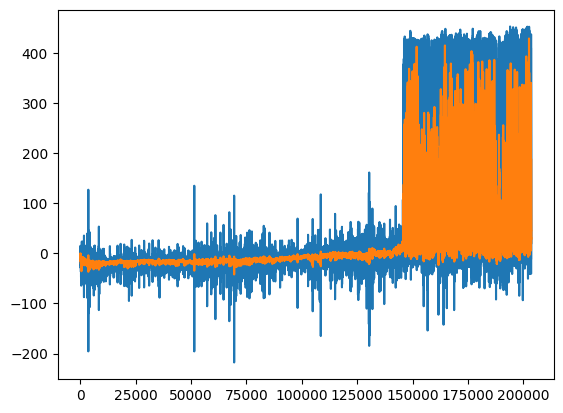

In [6]:
plt.plot(trackR)
plt.plot(avgR)


In [ ]:
env.env._action



In [5]:
# import gym
# from gym.wrappers.monitoring.video_recorder import VideoRecorder
import gym
# from gym.wrappers.monitoring.video_recorder import VideoRecorder
from torch import nn
import torch.nn.functional as F
import torch
import random 
import matplotlib.pyplot as plt
import numpy as np
from gym_jiminy.envs import ANYmalJiminyEnv
import numpy as np
## Observation and action space size
observationNum = 37
actionNum = 12
totalNum = observationNum + actionNum

## Training Parameters
epochs = 200
batchSize = 128
gpu = False
rewardTracking = []
rewardAvg = []
replayMemorySize = 10000
printE = 10
path = '/home/linghao/Desktop/'
updateStart = 5000
policyDelay = 4
## Initialise TD3 agent

newEnv = GymWrapper(ConfigurableANYmal())
 

agentEval = TD3Agent(newEnv.action_space,
                (observationNum, 256, 128, actionNum), 
                (totalNum, 256, 128, actionNum), 
                actorLRate = 0.0001, criticLRate = 0.0001, criticLoss = 'HL', gamma = 0.95, targetUpdaterLRate = 0.05,
                replayMemorySize = replayMemorySize, gpu=gpu, batchSize=batchSize, policyDelay = policyDelay)

agentEval.loadModel('/home/linghao/Desktop')
agentEval.evalMode()


observation = newEnv.reset()

 
# video_recorder = VideoRecorder(newEnv, '/home/linghao/Desktop/Ant.mp4', enabled=True)

# R = 0

# for Iter in range(7000):
# #     video_recorder.capture_frame()
#     observation, reward, terminated, truncated, info = newEnv.step(agentEval.getAction(observation, eval = True))
# #     observation, reward, terminated, info = newEnv.env.step() 
#     R += reward
    
#     if terminated:
#         print('Term')
#         break
# #     elif truncated:
# #         print('Outbound')
# #         break
#     else:
#         continue
# # video_recorder.close()
# # video_recorder.enabled = False

# newEnv.stop()
# camera_xyzrpy = ([5.0, 2.0, 0.0], [np.pi/2, 0.0, np.pi/1.5])
# newEnv.env.simulator.replay(camera_xyzrpy=camera_xyzrpy)

In [47]:
R = 0

from gym_jiminy.envs import ANYmalPDControlJiminyEnv
from gym_jiminy.envs import ANYmalJiminyEnv

newEnv = GymWrapper(ConfigurableANYmal())
newEnv.env.seed()

observation = newEnv.reset()
ac = []
inf = []
# agent.evalMode()


for Iter in range(7000):
#     video_recorder.capture_frame()
    actions = agentEval.getAction(observation, eval = False)
    observation, reward, terminated, truncated, info = newEnv.step(actions)
    ac.append(actions)
    inf.append(info)
#     observation, reward, terminated, info = newEnv.step(newEnv.action_space.sample()) 
    R += reward
    
    if terminated:
#         print('Term')
#         newEnv.env.reset()
        break
#     elif truncated:
#         print('Outbound')
#         break
    else:
        continue
# video_recorder.close()
# video_recorder.enabled = False


# newEnv.stop()
# camera_xyzrpy = ([5.0, 2.0, 1.0], [np.pi/2, 0.0, np.pi/1.5])
# newEnv.simulator.replay(camera_xyzrpy=camera_xyzrpy)


In [48]:
Iter *0.04

8.68

In [49]:
R

157.11438009560862

In [50]:
newEnv.env.observe_dt = 0.04
newEnv.stop()
camera_xyzrpy = ([5.0, 2.0, 1.0], [np.pi/2, 0.0, np.pi/1.5])
newEnv.simulator.replay(camera_xyzrpy=camera_xyzrpy)

In [46]:
newEnv.simulator.stop()
newEnv.simulator.close()
newEnv.env.close()

In [ ]:
agentEval.rMemory.isFull()


In [ ]:
newEnv.env._height_neutral 


In [ ]:
inf

In [ ]:
info

In [ ]:
inf

In [38]:
newEnv.env.replay()

In [41]:
newEnv.env.close()